# 0. Import libraries

The libraries used to create the data are in the following cell

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

from modeling import * 
from constants import DATA_FOLDER_PATH

2023-09-27 11:41:17.461373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 11:41:18.055788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# 1. Define constants

This section defines constants to specify the location of the data and where the model will be stored

In [2]:
# Path to the files where the data for the training is
FEATURES_FILENAME = "surfaces_linear.npy"
LABELS_FILENAME = "coefficients_linear.npy"

FEATURES_FILE_PATH = f"{DATA_FOLDER_PATH}/{FEATURES_FILENAME}"
LABELS_FILE_PATH = f"{DATA_FOLDER_PATH}/{LABELS_FILENAME}"

# 2. Read data

Get train, validation and test data

In [3]:
train_features, \
train_labels, \
val_features, \
val_labels, \
test_features, \
test_labels = read_data_for_training(FEATURES_FILE_PATH,
                                     LABELS_FILE_PATH)

# 3. Define hyperparameters for neural network

In the first place define the hyperparameters of the neural network

In [4]:
# Neural network architecture hyperparameters
input_shape = train_features[0].shape
output_size = len(train_labels[0])
hidden_layer_sizes = [512, 256, 64]
regularizer = keras.regularizers.L1L2(l1=0.001,l2=0.1)
hidden_activation = 'relu'
output_activation = 'linear'
use_batch_normalization = True
name = 'TestModel'

# Compilation hyperparameters
loss_function = tf.keras.losses.MeanSquaredError()
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)
metric = tf.keras.metrics.MeanSquaredError()

# Training hyperparameters
epochs = 3
batch_size = 512
reduce_lr = ReduceLROnPlateau('mean_squared_error', factor=0.1, patience=150, verbose=1)
early_stop = EarlyStopping('mean_squared_error', patience=500, verbose=1)
callbacks = [reduce_lr, early_stop]

2023-09-27 11:41:18.954497: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 11:41:18.972913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-27 11:41:18.973099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# 4. Train Network

Create the architecture

In [5]:
surface_reconstructor_model = create_linear_architecture(input_shape,
                                                         output_size,
                                                         hidden_layer_sizes,
                                                         regularizer,
                                                         hidden_activation,
                                                         output_activation,
                                                         use_batch_normalization=use_batch_normalization,
                                                         name=name)

Compile the model

In [6]:
compile_linear_model(surface_reconstructor_model,
                     loss_function,
                     optimizer,
                     metric
                     )

Fit the model

In [7]:
history = train_linear_model(surface_reconstructor_model,
                             train_features,
                             train_labels,
                             batch_size,
                             epochs,
                             val_features,
                             val_labels,
                             callbacks)

Epoch 1/3


2023-09-27 11:41:21.085040: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-09-27 11:41:21.088800: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f7b780130b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-27 11:41:21.088831: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2023-09-27 11:41:21.097728: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-27 11:41:21.236074: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-09-27 11:41:21.333521: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifeti

94/94 [==============================] - 3s 9ms/step - loss: 27.9237 - mean_squared_error: 8.7482 - val_loss: 16.4366 - val_mean_squared_error: 13.3189 - lr: 0.0100
Epoch 2/3
94/94 [==============================] - 1s 7ms/step - loss: 6.3465 - mean_squared_error: 3.6253 - val_loss: 11.9537 - val_mean_squared_error: 9.5617 - lr: 0.0100
Epoch 3/3
94/94 [==============================] - 1s 5ms/step - loss: 5.1719 - mean_squared_error: 3.1838 - val_loss: 8.7916 - val_mean_squared_error: 7.0412 - lr: 0.0100


# 5. Check training process

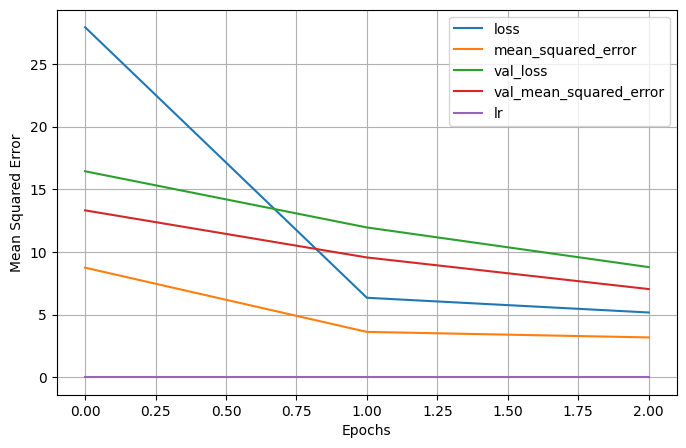

In [8]:
plot_model_history(history)

# 6. Save model and description

In [9]:
description = f"# Neural network architecture hyperparameters \n\
input_size = train_features[0].shape \n\
output_size = len(train_labels[0]) \n\
hidden_layer_sizes = [512, 256, 64] \n\
regularizer = keras.regularizers.L1L2(l1=0.001,l2=0.1) \n\
hidden_activation = 'relu' \n\
output_activation = 'linear' \n\
use_batch_normalization = True \n\
name = 'LinearSurfaceReconstructor' \n\
# Compilation hyperparameters \n\
loss_function = tf.keras.losses.MeanSquaredError() \n\
learning_rate = 0.01 \n\
optimizer = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999) \n\
metric = tf.keras.metrics.MeanSquaredError() \n\
# Training hyperparameters \n\
epochs = 750 \n\
batch_size = 512 \n\
reduce_lr = ReduceLROnPlateau('mean_squared_error', factor=0.1, patience=150, verbose=1) \n\
early_stop = EarlyStopping('mean_squared_error', patience=500, verbose=1) \n\
callbacks = [reduce_lr, early_stop]"

store_model(surface_reconstructor_model,
            name,
            description)

AttributeError: '_io.TextIOWrapper' object has no attribute 'writeline'